# InSAR typical operations in Xarray and Zarr

This is an example Jupyter notebook to realize the typical InSAR operations with Xarray and Zarr. The following operations are covered:

- Writing a pointset in `xarray.DataArray` to `zarr` storage with chunks
- Subsetting pointset
- Appending saving the new variables
- Reconstruct raster grid from the saved raster coordinates

## Setup environment and testing data

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In this example, we will initiate a mannual defined data cube as a representation of the corregistered InSAR images

In [2]:
# Set data cube dimension
n_azimuth=2000
n_range=1000
n_time=4

In [3]:
# signal
signal = np.zeros((n_azimuth,n_range,n_time))
signal[:,:,0] = np.tile(np.linspace(0,np.pi,num=n_range), (n_azimuth,1))
for i in range(1,n_time):
    signal[:,:,i] = signal[:,:,0]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_azimuth,n_range,n_time)*2*np.pi

# obs
obs = signal + noise

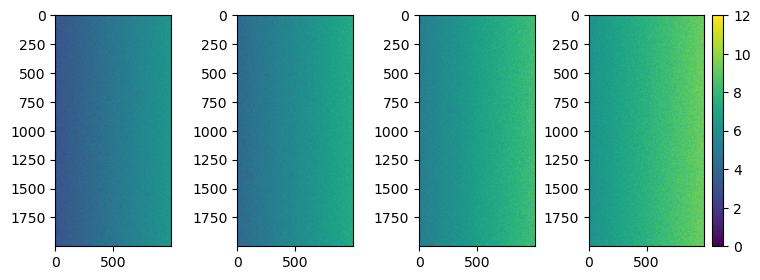

In [4]:
# Visualize the simulated data
fig, ax = plt.subplots(1,n_time)
fig.set_size_inches(9,3)
for i in range(n_time):
    im = ax[i].imshow(obs[:,:,i], vmin=0, vmax=12)
plt.colorbar(im)

## Export to Zarr storage

We can use the following code to convert the dummy datacube to an `xr.DataSet` object

In [5]:
ds = xr.Dataset(
    data_vars=dict(
        obs=(["azimuth", "range", "time"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
    ),
)
ds

<xarray.Dataset>
Dimensions:  (azimuth: 2000, range: 1000, time: 4)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (azimuth, range, time) float64 3.448 5.494 5.787 ... 7.007 7.702

The datacube is 3D, with two space coordinates and one time coordinates. It can be converted to a pointset for the convenience of processing:

In [6]:
# Convert to pointset by stacking two dimensions
ds_pointset = ds.stack(points=('azimuth', 'range'))
ds_pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 2000000)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    obs      (time, points) float64 3.448 2.665 6.061 3.579 ... 9.354 10.3 7.702

Here we use the `stack` function to reshape the dataset, and create a new coordinate: `points`. As the name of the function suggested, the `points` coordinates is a stacked coordinate, or a `MultiIndex`, created from `azimuth` and `range`:

In [7]:
ds_pointset.points

<xarray.DataArray 'points' (points: 2000000)>
array([(0, 0), (0, 1), (0, 2), ..., (1999, 997), (1999, 998), (1999, 999)],
      dtype=object)
Coordinates:
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [8]:
# Tranpose for InSAR data convention
ds_pointset = ds_pointset.transpose("points", "time")
ds_pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 2000000)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    obs      (points, time) float64 3.448 5.494 5.787 ... 10.29 7.007 7.702

However, we cannot directly save a `xr.DataSet` with a `MultiIndex` dimension to `Zarr`. This is currently [an ongoing issue of Xarray](https://github.com/pydata/xarray/issues/1077).

In [9]:
# Will fail, because "to_Zarr" currently does not support Multi-Indexing: 
# ds_pointset.to_zarr("database.zarr", mode='w') # For this example, use "w" flag to overwrite everytime.

The solution can be replacing the newly created Multi-Index `points` coordinates with a real coordiantes. Since the raster coordinates are stored in `azimuth` and `range` coordinates, we can use these coordinates to restore the raster grid later.

In [10]:
# Re-construct the coordinates for the "point" dimension
ds_pointset = ds_pointset.reset_index("points")
ds_pointset['points'] = xr.DataArray(data=range(ds_pointset.points.size), dims=["points"])
ds_pointset

<xarray.Dataset>
Dimensions:  (points: 2000000, time: 4)
Coordinates:
  * time     (time) int64 0 1 2 3
    azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
    range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * points   (points) int64 0 1 2 3 4 ... 1999996 1999997 1999998 1999999
Data variables:
    obs      (points, time) float64 3.448 5.494 5.787 ... 10.29 7.007 7.702

However `ds_pointset` still cannot be stored to Zarr. This is because a strange behavior of the `to_index` function which is used to check the multi-index for `azimuth` and `range`. The following code block should give a single index, but gives a multi-index instead. This could potentially be a caching issue of `xarray`. Need to confirm this later.

In [11]:
# One suspicious behavior , the following command gives a 2-D multi index but it should be 1-D. This will cause Zarr saving to fail
ds_pointset.azimuth.to_index()

# # This seem to be an cache issue of the `to_index`` function. The following script gives correct results:
# vals = ds_pointset.azimuth.values

# ds_test = xr.Dataset(
#     data_vars=dict(
#         obs=(["azi"], vals),
#     ),
#     coords=dict(
#         # azi=np.arange(vals.size)
#         azi=vals
#     ),
# )
# ds_test

# ds_test.azi.to_index()

Int64Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            ...
            1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999],
           dtype='int64', name='azimuth', length=2000000)

The solution can be replacing the `azimuth` and `range` coordinates by themselves 

In [12]:
# Overite the "azimuth" and "range" coordinates. The coordinates stays the same
ds_pointset['azimuth'] = xr.DataArray(data=ds_pointset.azimuth.values, dims=["points"])
ds_pointset['range'] = xr.DataArray(data=ds_pointset.range.values, dims=["points"])
ds_pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 2000000)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) int64 0 1 2 3 4 ... 1999996 1999997 1999998 1999999
    azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
    range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    obs      (points, time) float64 3.448 5.494 5.787 ... 10.29 7.007 7.702

No the `to_index` function gives the correct results.

In [13]:
# However the "to_index" function gives the correct output now
ds_pointset.azimuth.to_index()

Int64Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            ...
            1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999],
           dtype='int64', name='points', length=2000000)

Now we are going to store the the pointset to a `Zarr` storage. We would like to separate the points in spatial trunks for later concurrent accessing. First we check if there is any existing trunks 

In [14]:
# Check the current chunks of dataset, there should be none
ds_pointset.chunks

Frozen({})

We can customly define a trunk size:

In [15]:
# Chunk in the "points" dimension
ds_pointset = ds_pointset.chunk({"points":450000})
ds_pointset.chunks

Frozen({'points': (450000, 450000, 450000, 450000, 200000), 'time': (4,)})

Then the data can be saved in chunks:

In [16]:
# Export to Zarr
ds_pointset.to_zarr("database.zarr", mode='w') # For this example, use "w" flag to overwrite everytime.

In [17]:
# Check Zarr storage volume and file structure
! du -h --max-depth=0 database.zarr
! tree database.zarr

55M	database.zarr
database.zarr
├── azimuth
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   └── 4
├── obs
│   ├── 0.0
│   ├── 1.0
│   ├── 2.0
│   ├── 3.0
│   └── 4.0
├── points
│   ├── 0
│   ├── 1
│   ├── 10
│   ├── 11
│   ├── 12
│   ├── 13
│   ├── 14
│   ├── 15
│   ├── 16
│   ├── 17
│   ├── 18
│   ├── 19
│   ├── 2
│   ├── 20
│   ├── 21
│   ├── 22
│   ├── 23
│   ├── 24
│   ├── 25
│   ├── 26
│   ├── 27
│   ├── 28
│   ├── 29
│   ├── 3
│   ├── 30
│   ├── 31
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
├── range
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   └── 4
└── time
    └── 0

5 directories, 48 files


## Subsetting

Now we are going to give an example of subetting. First we load the saved `Zarr` storage:

In [18]:
ds_pointset = xr.open_zarr("database.zarr")
ds_pointset

<xarray.Dataset>
Dimensions:  (points: 2000000, time: 4)
Coordinates:
    azimuth  (points) int64 dask.array<chunksize=(450000,), meta=np.ndarray>
  * points   (points) int64 0 1 2 3 4 ... 1999996 1999997 1999998 1999999
    range    (points) int64 dask.array<chunksize=(450000,), meta=np.ndarray>
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (points, time) float64 dask.array<chunksize=(450000, 4), meta=np.ndarray>

Then we select the pixel with low STD, and make a mask:

In [19]:
mask = ds_pointset.obs.std(axis=1)<0.5
mask

<xarray.DataArray 'obs' (points: 2000000)>
dask.array<lt, shape=(2000000,), dtype=bool, chunksize=(450000,), chunktype=numpy.ndarray>
Coordinates:
    azimuth  (points) int64 dask.array<chunksize=(450000,), meta=np.ndarray>
  * points   (points) int64 0 1 2 3 4 ... 1999996 1999997 1999998 1999999
    range    (points) int64 dask.array<chunksize=(450000,), meta=np.ndarray>

The `mask` can be used to select the qualified points:

In [20]:
# Select the low std pixels
ds_pointset_masked = ds_pointset.where(mask)
ds_pointset_masked = ds_pointset_masked.dropna('points', subset=['obs'])
ds_pointset_masked

<xarray.Dataset>
Dimensions:  (points: 34630, time: 4)
Coordinates:
    azimuth  (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * points   (points) int64 76 133 151 156 ... 1999867 1999940 1999970 1999998
    range    (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (points, time) float64 dask.array<chunksize=(7819, 4), meta=np.ndarray>

## Append writing to Zarr storage

Now we selected a subset of the orginal poinset `ds_pointset`. Now we are going to look into updating. If we compute some new features from the original pointset, we can save it appendingly to the `Zarr` storage.

We here add a new variable `selection_flag` to the selected pointset `ds_pointset_masked`, indicating if a point is selected.

In [21]:
ds_pointset_masked = ds_pointset_masked.assign(
    selection_flag=("points", np.ones((ds_pointset_masked.points.size)))
)
ds_pointset_masked

<xarray.Dataset>
Dimensions:         (points: 34630, time: 4)
Coordinates:
    azimuth         (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * points          (points) int64 76 133 151 156 ... 1999940 1999970 1999998
    range           (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * time            (time) int64 0 1 2 3
Data variables:
    obs             (points, time) float64 dask.array<chunksize=(7819, 4), meta=np.ndarray>
    selection_flag  (points) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

We can merge this data to the original DataSet:

In [22]:
ds_pointset_update = xr.open_zarr("database.zarr")
ds_pointset_update = xr.merge((ds_pointset_update,ds_pointset_masked))
ds_pointset_update

<xarray.Dataset>
Dimensions:         (points: 2000000, time: 4)
Coordinates:
  * points          (points) int64 0 1 2 3 4 ... 1999996 1999997 1999998 1999999
  * time            (time) int64 0 1 2 3
    azimuth         (points) float64 dask.array<chunksize=(450058,), meta=np.ndarray>
    range           (points) float64 dask.array<chunksize=(450058,), meta=np.ndarray>
Data variables:
    obs             (points, time) float64 dask.array<chunksize=(450058, 4), meta=np.ndarray>
    selection_flag  (points) float64 nan nan nan nan nan ... nan nan nan 1.0 nan

And append it to the Zarr storage:

In [23]:
# Update zarr database
ds_pointset_update.to_zarr("database.zarr", mode='a')

/home/ouku/miniconda3/envs/mobyle_demo/lib/python3.10/site-packages/xarray/core/dataset.py:2077: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
/home/ouku/miniconda3/envs/mobyle_demo/lib/python3.10/site-packages/xarray/core/dataset.py:2077: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore


In [24]:
#Check size
! du -h --max-depth=0 database.zarr

56M	database.zarr


## Reconstruct the raster grid

In this section we will recontruct the original raster grid from the saved raster coordinates.

First we read the subset pointset selected with the standard deviation

In [25]:
ds_pointset = xr.open_zarr("database.zarr")
ds_pointset_masked = ds_pointset.dropna('points', subset=['selection_flag'])
ds_pointset_masked

<xarray.Dataset>
Dimensions:         (points: 34630, time: 4)
Coordinates:
    azimuth         (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * points          (points) int64 76 133 151 156 ... 1999940 1999970 1999998
    range           (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * time            (time) int64 0 1 2 3
Data variables:
    obs             (points, time) float64 dask.array<chunksize=(7819, 4), meta=np.ndarray>
    selection_flag  (points) float64 dask.array<chunksize=(1153,), meta=np.ndarray>

Then we take out the `selection_flag` variable as a `DataArray`.

In [26]:
mask_selection_flag = ds_pointset_masked.selection_flag
mask_selection_flag

<xarray.DataArray 'selection_flag' (points: 34630)>
dask.array<getitem, shape=(34630,), dtype=float64, chunksize=(1153,), chunktype=numpy.ndarray>
Coordinates:
    azimuth  (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>
  * points   (points) int64 76 133 151 156 ... 1999867 1999940 1999970 1999998
    range    (points) int64 dask.array<chunksize=(7819,), meta=np.ndarray>

We can sign a manually created `Multi-Index` to the `points` coodrinates agai, build from `azimuth` and `range`

In [27]:
# Inspired by the recent release: https://github.com/pydata/xarray/issues/6752
import pandas
def _create_multiindex(**kwargs):
    return pandas.MultiIndex.from_arrays(list(kwargs.values()), names=kwargs.keys())

# Assigin the multi-index again to the "points" coordinates
mask_selection_flag.coords["points"] =  _create_multiindex(azimuth=mask_selection_flag.azimuth.values, range=mask_selection_flag.range.values)
mask_selection_flag

<xarray.DataArray 'selection_flag' (points: 34630)>
dask.array<getitem, shape=(34630,), dtype=float64, chunksize=(1153,), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * points   (points) object MultiIndex
  * range    (points) int64 76 133 151 156 167 175 ... 850 865 867 940 970 998

Then use the `unstack` command to restore the original raster grid

In [28]:
mask_selection_flag.unstack()

<xarray.DataArray 'selection_flag' (azimuth: 2000, range: 1000)>
dask.array<reshape, shape=(2000, 1000), dtype=float64, chunksize=(63, 1000), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999